In [1]:
# -*- coding: utf-8 -*-
"""topovae_fashionmnist5.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1ko-KioUOGVqgcCvSJRQjD-QRrgFYhWSB
"""

# Install necessary packages
!pip3 install giotto-ph ipython Cython ripser tadasets persim torchvision tqdm six Pillow
import sys
!{sys.executable} -m pip install giotto-tda

# Install necessary packages
!pip3 install giotto-ph ipython Cython ripser tadasets persim torchvision tqdm six Pillow giotto-tda

# Import standard libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import scipy
import os
import argparse

# Import PyTorch related libraries
import torch
from torch import nn, optim
from torch.nn import functional as F
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torchvision.utils
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid, save_image
# Import image handling libraries
import PIL.Image as Image
from IPython.display import Image as IPyImage
# Import TDA libraries
import ripser
import persim
import tadasets
from gph import ripser_parallel
from gtda.homology._utils import _postprocess_diagrams
from gtda.plotting import plot_diagram, plot_point_cloud
from sklearn import datasets
from plotly import graph_objects as go
import torchvision.datasets as datasets

import math

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

"""Topological regularizers:"""

## push0 and push1 are not used here

def get_dgm(point_cloud, deg):
  # Compute the persistence diagram without backprop
  with torch.no_grad():
        ##convert points for computing PD:
        points_np = point_cloud.numpy()
        # get PD with generators:
        dgm = ripser_parallel(points_np, maxdim=deg, return_generators=True)
  return dgm

#euclidean dist for torch tensors:
def dist(point1, point2):
    return torch.sqrt(torch.sum((point2 - point1)**2))

#euclidean dist for numpy points:
def dist_np(point1, point2):
    return np.sqrt(np.sum((point2 - point1)**2))

#supremum dist for torch tensors:
def dist_sup_tc(b1, d1, b2, d2):
    # Calculate the sup norm between points (b1, d1) and (b2, d2)
    return torch.max(torch.abs(b1 - b2), torch.abs(d1 - d2))

def d_bottleneck0(point_cloud, dgm, dgm2): # got_loss=1 if got loss, =0 if loss does not depend on dgm
    got_loss = 1
    with torch.no_grad():
        distance_bottleneck, matching = persim.bottleneck(dgm['dgms'][0][:-1], dgm2['dgms'][0][:-1], matching=True)
        #find the pair that gives the max distance:
        index = np.argmax(matching[:, 2])
        i, j = int(matching[index][0]), int(matching[index][1]) #i, j: the i-th and j-th point of the dgm1, dgm2 respectively, that give the bottleneck dist.
        # (if the largest dist is point<->diagonal: i or j is -1)
        #i is the i-th pt in dgm and j is the j-th pt in dgm2 which give the bottleneck dist (i.e. it is the largest dim)
        #for the loss, need to know what is the point i (learnable), i=(distmatrix[xi,yi],distmatrix[ai,bi]) in the distance matrix for some 4 indices
        #but gen[0]
        # i is the index of a point of the PD. but (gens[i][1], gens[i][2]) is the pair of vertices of the point cloud that correspond to the point i=(0,d), with d=dist(gens[i][1]-gens[i][2])
        #get the 2 points that give the distance of the i-th pt in dgm in the 1st diagram and compute the loss:
    if i>=0:
      point1_dgm1 = point_cloud[dgm['gens'][0][i][1]]
      point2_dgm1 = point_cloud[dgm['gens'][0][i][2]]

    if i>=0 and j>=0:
      loss = torch.abs(dist(point1_dgm1, point2_dgm1) - dgm2['dgms'][0][j][1])
    else:
      if i==-1: #so the j-th point from dgm2 is matched to the diagonal -> backprop through loss would give 0 -> goal: make points further from diag
        #new_bdist = torch.abs(dist(point1_dgm2, point2_dgm2) - 0.)/2
        loss = dgm2['dgms'][0][j][1]/2.
        got_loss = 0
      else: #then  j==-1, so the i-th point from dgm1 is matched to the diagonal
        loss = dist(point1_dgm1, point2_dgm1)/2.

    return loss, got_loss

def d_bottleneck1(point_cloud, dgm, dgm2): # got_loss=1 if got loss, =0 if loss does not depend on dgm
    got_loss = 1
    if len(dgm['dgms'][1])==0: return 0, 0
    if len(dgm2['dgms'][1])==0: dgm2['dgms'][1] = [[0.,0.]] #print("error2")
    with torch.no_grad():
        distance_bottleneck, matching = persim.bottleneck(dgm['dgms'][1], dgm2['dgms'][1], matching=True)
        #find the pair that gives the max distance:
        index = np.argmax(matching[:, 2])
        i, j = int(matching[index][0]), int(matching[index][1])
        #i is the i-th pt in dgm and j is the j-th pt in dgm2 which give the bottleneck dist (i.e. it is the largest dim)
        #for the loss, need to know what is the point i (learnable), i=(distmatrix[xi,yi],distmatrix[ai,bi]) in the distance matrix for some 4 indices
        # i is the index of a point of the PD. but (gens[i][1], gens[i][2]) is the pair of vertices of the point cloud that correspond to the point i=(0,d), with d=dist(gens[i][1]-gens[i][2])

    #get the 2 points that give the distance of the i-th pt in dgm in the 1st diagram:
    #if i>0, then the pt of dgm1 is off-diag:
    if i>=0:
      point0_dgm1 = point_cloud[dgm['gens'][1][0][i][0]]
      point1_dgm1 = point_cloud[dgm['gens'][1][0][i][1]]
      point2_dgm1 = point_cloud[dgm['gens'][1][0][i][2]]
      point3_dgm1 = point_cloud[dgm['gens'][1][0][i][3]]
      birth_dgm1 = dist(point0_dgm1, point1_dgm1)
      death_dgm1 = dist(point2_dgm1, point3_dgm1)
    #get the 2 points that give the distance of the j-th pt in dgm in the 2nd diagram:
    if j>=0:
      birth_dgm2 = dgm2['dgms'][1][j][0]
      death_dgm2 = dgm2['dgms'][1][j][1]

    if i>=0 and j>=0:
      loss = dist_sup_tc(birth_dgm1, death_dgm1, birth_dgm2, death_dgm2)
    else:
      if i==-1: #so the j-th point from dgm2 is matched to the diagonal
        loss = (death_dgm2 - birth_dgm2)/2.
        got_loss = 0
      else: #then j==-1, so the i-th point from dgm1 is matched to the diagonal
        loss = (death_dgm1 - birth_dgm1)/2.

    return loss, got_loss

def dist_2(a, b, c, d):
    return (a - c)**2 + (b - d)**2

#return Reininghaus kernel ksigma: (could make it slightly faster with different functions for each dgm (dgm2 does not need backpropagation)), but let it same for all dgms
def ksigma0(point_cloud, point_cloud2, dgm, dgm2): #maxdim of both dgms: 0
    sigma = 0.05
    ksigma = 0
    ## use formula for k_sigma from paper (https://arxiv.org/pdf/1412.6821.pdf):
    for i in range(len(dgm['gens'][0])):
        # pt in dgm: (0,d), d=dist(p1,p2)
        p1, p2 = point_cloud[dgm['gens'][0][i][1]], point_cloud[dgm['gens'][0][i][2]]
        d1 = dist(p1, p2)
        for j in range(len(dgm2['gens'][0])):
           #pt in dgm2: (0,d), d=dist(q1,q2)
           q1, q2 = point_cloud2[dgm2['gens'][0][j][1]], point_cloud2[dgm2['gens'][0][j][2]]
           d2 = dist(q1, q2)
           ksigma += torch.exp(-dist_2(0, d1, 0, d2)/(8*sigma)) - torch.exp(-dist_2(0, d1, d2, 0)/(8*sigma))

    ksigma *= 1/(8*3.141592*sigma)
    return ksigma

#return pseudo-distance that comes from ksigma and squared, dsigma**2:
def dsigma0(point_cloud, point_cloud2, dgm, dgm2):
    k11 = ksigma0(point_cloud, point_cloud, dgm, dgm)
    #k22 = ksigma(point_cloud2, point_cloud2)
    k12 = ksigma0(point_cloud, point_cloud2, dgm, dgm2)
    #return k11 + k22 - 2*k12
    return k11 - 2*k12 #no need of k22 since no backpropagation through it (fixed point cloud)

#the only diff from ksigma (deg0) is how to take the pt of dgms (b,d) wrt the pts of the point clouds, for the backpropagation
def ksigma1(point_cloud, point_cloud2, dgm, dgm2): #maxdim of both dgms: 1
    sigma = 0.05
    if len(dgm['dgms'][1])==0 or len(dgm['dgms'][1])==0: return 0, 0

    ksigma1 = 0
    ## use formula for k_sigma from paper (https://arxiv.org/pdf/1412.6821.pdf):
    for i in range(len(dgm['gens'][1])):
        # pt in dgm: (b1,d1), with b1, d1 = dist(p2, p1), dist(dist(p3, p4)
        p1, p2, p3, p4 = point_cloud[dgm['gens'][1][0][i][0]], point_cloud[dgm['gens'][1][0][i][1]], point_cloud[dgm['gens'][1][0][i][2]], point_cloud[dgm['gens'][1][0][i][3]]
        b1 = dist(p1,p2)
        d1 = dist(p3,p4)

        for j in range(len(dgm2['gens'][1])):
          #pt in dgm2: (b2,d2)
          q1, q2, q3, q4 = point_cloud2[dgm2['gens'][1][0][j][0]], point_cloud2[dgm2['gens'][1][0][j][1]], point_cloud2[dgm2['gens'][1][0][j][2]], point_cloud2[dgm2['gens'][1][0][j][3]]
          b2 = dist(q1,q2)
          d2 = dist(q3,q4)

          ksigma1 += torch.exp(-dist_2(b1, d1, b2, d2)/(8*sigma)) - torch.exp(-dist_2(b1, d1, d2, b2)/(8*sigma))

    ksigma1 *= 1/(8*3.141592*sigma)
    return ksigma1, 1

def dsigma1(point_cloud, point_cloud2, dgm, dgm2):
    k12, gotloss = ksigma1(point_cloud, point_cloud2, dgm, dgm2)
    if gotloss == 0: return 0, 0
    # if both dgm and dgm2 have at least 1 point:
    k11, gotloss = ksigma1(point_cloud, point_cloud, dgm, dgm)
    return k11 + (-2.) * k12, 1

def density(point_cloud, dgm, sigma, scale, x):
  tot = 0
  density_x = 0 #density at x
  for i in range(len(dgm['dgms'][0])-1):
    p1, p2 = point_cloud[dgm['gens'][0][i][1]], point_cloud[dgm['gens'][0][i][2]] #pt (0,d) with d=dist(p1,p2) (euclidean dist)
    d = dist(p1, p2) #pt of pt cloud is (0,d)
    density_x += d**4 * torch.exp(-((d-x)/sigma)**2)

  return density_x * scale

def loss_density(point_cloud, point_cloud2, dgm, dgm2, sigma, scale, maxrange, npoints, plot): #dgm of deg0
  xs = np.linspace(0., maxrange, npoints)
  loss = 0
  ## compute difference between both functions in 100 pts (those given by xs)
  dens=[]
  dens0=[]
  for x in xs:
    dx = density(point_cloud, dgm, sigma, scale, x)
    d0x = density(point_cloud2, dgm2, sigma, scale, x)
    loss += (dx - d0x)**2
    if plot:
      with torch.no_grad():
        dens.append(dx.detach().numpy())
        dens0.append(d0x.detach().numpy())

  if plot: #plot both density functions (blue: the one of dgm being learned)
    plt.plot(xs, dens, color='blue')
    plt.plot(xs, dens0, color='red')
    plt.show()

  return loss

## use: sigma=0.2, scale=0.002, maxrange=35., npoints=100

def loss_persentropy0(point_cloud, dgm, dgm2, delta): #dgm of deg0. only looks at points with pers=|d|>delta (for avoiding large gradients) (in both dgms)
  L = 0
  for i in range(len(dgm['dgms'][0])-1):
    with torch.no_grad(): pers1 = dist(point_cloud[dgm['gens'][0][i][1]], point_cloud[dgm['gens'][0][i][2]])
    if pers1>delta: L += dist(point_cloud[dgm['gens'][0][i][1]], point_cloud[dgm['gens'][0][i][2]])

  with torch.no_grad():
    if L==0: return 0, 0

  pers = 0
  for i in range(len(dgm['dgms'][0])-1):
    p1, p2 = point_cloud[dgm['gens'][0][i][1]], point_cloud[dgm['gens'][0][i][2]] #pt (0,d) with d=dist(p1,p2) (euclidean dist)
    with torch.no_grad(): d1 = dist(p1, p2)
    if d1>delta: pers += dist(p1, p2) * torch.log(dist(p1, p2)/L) #pt of pt cloud is (0,dist(p1, p2))

  ##get pers entropy of dgm2:
  L2 = 0
  pers2 = 0
  for i in range(len(dgm2['dgms'][0])-1):
    if dgm2['dgms'][0][i][1] > delta: L2 += dgm2['dgms'][0][i][1]
  if L2==0: return (pers/L)**2, 1
  for i in range(len(dgm2['dgms'][0])-1):
    if dgm2['dgms'][0][i][1] > delta: pers2 += dgm2['dgms'][0][i][1] * math.log(dgm2['dgms'][0][i][1] / L2)

  return (pers/L - pers2/L2)**2, 1

def loss_persentropy1(point_cloud, dgm, dgm2, delta): #dgm of deg1. returns loss, got_loss (0 if did not get it). only looks at points with pers=|d-b|>delta (in both dgms) (for avoiding large gradients)
  if len(dgm['dgms'][1])==0: return 0, 0 #no loss if dgm has no off-diag points

  #entropy of dgm:
  L = 0
  for i in range(len(dgm['dgms'][1])):
        # pt in dgm: (b1,d1), with b1, d1 = dist(p2, p1), dist(dist(p3, p4)
        p1, p2, p3, p4 = point_cloud[dgm['gens'][1][0][i][0]], point_cloud[dgm['gens'][1][0][i][1]], point_cloud[dgm['gens'][1][0][i][2]], point_cloud[dgm['gens'][1][0][i][3]]
        b1 = dist(p1,p2)
        d1 = dist(p3,p4)
        with torch.no_grad(): pers1 = d1-b1
        if pers1 > delta: L += d1 - b1

  with torch.no_grad():
    if L==0: return 0, 0

  pers = 0
  for i in range(len(dgm['gens'][1])):
        # pt in dgm: (b1,d1), with b1, d1 = dist(p2, p1), dist(dist(p3, p4)
        p1, p2, p3, p4 = point_cloud[dgm['gens'][1][0][i][0]], point_cloud[dgm['gens'][1][0][i][1]], point_cloud[dgm['gens'][1][0][i][2]], point_cloud[dgm['gens'][1][0][i][3]]
        b1 = dist(p1,p2)
        d1 = dist(p3,p4)
        with torch.no_grad(): pers1 = d1-b1
        if pers1 > delta: pers += (d1-b1) * torch.log((d1-b1)/L)

  if len(dgm2['dgms'][1])==0: return (pers/L)**2, 1 # the pers of dgm2 is taken as 0

  #entropy of dgm2:
  L2 = 0
  for i in range(len(dgm2['dgms'][1])):
        if dgm2['dgms'][1][i][1] - dgm2['dgms'][1][i][0]>delta: L2 += dgm2['dgms'][1][i][1] - dgm2['dgms'][1][i][0]

  if L2==0: return (pers/L)**2, 1 # the pers of dgm2 is taken as 0
  pers2 = 0
  for i in range(len(dgm2['dgms'][1])):
        lifespan = dgm2['dgms'][1][i][1] - dgm2['dgms'][1][i][0]
        if lifespan>delta: pers2 += torch.tensor(lifespan) * torch.log(torch.tensor(lifespan/L2))

  return (pers/L - pers2/L2)**2, 1

"""Experiments with VAE and MNIST:
0. No topoloss2
1. loss_topo0
2. loss_topo0 + loss_topo1
3. loss_persentropy0 + loss_persentropy1
4. loss_persentropy0 + dsigma1
5. density0 + dsigma1
6. dsigma0 + dsigma1

Note: the losses loss_topo0, 1, dsigma1, loss_persentropy1, return: (loss, got_loss) (1 if got the loss).

Build VAE:
"""

#from __future__ import print_function

seed = 1
batch_size = 128
epochs = 30
log_interval = 50
torch.manual_seed(seed)
img_size = 28*28

device = "cuda" if torch.cuda.is_available() else "cpu"

class VAE_Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define the VAE decoder
class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = F.relu(self.fc2(x))
        x = x.view(x.size(0), 64, 7, 7)
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        return x

# Define the VAE model that combines the encoder and decoder
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = VAE_Encoder(latent_dim)
        self.decoder = VAE_Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# Initialize the VAE with a desired latent dimension
latent_dim = 32  # You can adjust this as needed
vae = VAE(latent_dim)

"""Standard loss fctn and regularizers:"""

def loss_vae0(recon_x, x, mu, logvar, t):
    global losses, losses2, lossestopo, lossestopo2
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') #recon_x: fake batch of imgs, x: real batch of imgs

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    if t==0:
      losses.append(BCE.item())
      losses2.append(KLD.item())
    else:
      lossestopo.append(BCE.item())
      lossestopo2.append(KLD.item())

    return BCE + KLD

fids = []

def loss_fctn1(recon_x, x, mu, logvar, dgm, dgm2, w_topo0): #bottleneck0
    w_vae = 1.
    ## normal loss:
    loss = w_vae * loss_vae0(recon_x, x, mu, logvar, 1)
    ## compute topological loss:
    l_topo0, got_loss0 = d_bottleneck0(recon_x, dgm, dgm2)

    if got_loss0==1: loss += l_topo0 * w_topo0

    return loss

def loss_fctn2(recon_x, x, mu, logvar, dgm, dgm2, w_topo0, w_topo1): #bottleneck0+1
    w_vae = 1.
    ## normal loss:
    loss = w_vae * loss_vae0(recon_x, x, mu, logvar, 1)
    ## compute topological loss:
    l_topo0, got_loss0 = d_bottleneck0(recon_x, dgm, dgm2) #loss of degree 0
    l_topo1, got_loss1 = d_bottleneck1(recon_x, dgm, dgm2) #loss of degree 1

    if got_loss0==1: loss += l_topo0 * w_topo0
    if got_loss1==1: loss += l_topo1 * w_topo1

    return loss

def loss_fctn3(recon_x, x, mu, logvar, dgm, dgm2, w_topo0, w_topo1, delta): #pers entropy0+1. weights: 0.5, 0.5: does not learn. 0.3, 0.1: good
    w_vae = 1.
    ## normal loss:
    loss = w_vae * loss_vae0(recon_x, x, mu, logvar, 1)
    ## compute topological loss:
    l_topo0, got_loss0 = loss_persentropy0(recon_x, dgm, dgm2, delta) #loss of degree 0
    l_topo1, got_loss1 = loss_persentropy1(recon_x, dgm, dgm2, delta) #loss of degree 1

    if got_loss0==1: loss += l_topo0 * w_topo0
    if got_loss1==1: loss += l_topo1 * w_topo1

    return loss

def loss_fctn4(recon_x, x, mu, logvar, dgm, dgm2, w_topo0, w_topo1, delta): #pers entropy0+dsigma1. 0.5, 0.5: does not learn. 0.1, 0.3: relatively good.
    w_vae = 1.
    ## normal loss:
    loss = w_vae * loss_vae0(recon_x, x, mu, logvar, 1)
    ## compute topological loss:
    l_topo0, got_loss0 = loss_persentropy0(recon_x, dgm, dgm2, delta) #loss of degree 0
    l_topo1, got_loss1 = dsigma1(recon_x, x.view(-1, img_size), dgm, dgm2) #loss of degree 1

    if got_loss0==1: loss += l_topo0 * w_topo0
    if got_loss1==1: loss += l_topo1 * w_topo1

    return loss

def loss_fctn5(recon_x, x, mu, logvar, dgm, dgm2, w_topo0, w_topo1): # density0+dsigma1
    w_vae = 1.
    ## normal loss:
    loss = w_vae * loss_vae0(recon_x, x, mu, logvar, 1)
    ## compute topological loss:
    l_topo0 = loss_density(recon_x, x.view(-1, img_size), dgm, dgm2, 0.1, 0.0005, 15., 30, False) #loss of degree 0. loss_density(point_cloud, point_cloud2, dgm, dgm2, sigma, scale, maxrange, npoints, plot)
    l_topo1, got_loss1 = dsigma1(recon_x, x.view(-1, img_size), dgm, dgm2) #loss of degree 1

    loss += l_topo0 * w_topo0
    if got_loss1==1: loss += l_topo1 * w_topo1

    return loss

def loss_fctn6(recon_x, x, mu, logvar, dgm, dgm2, w_topo0, w_topo1): # dsigma0+dsigma1
    w_vae = 1.
    ## normal loss:
    loss = w_vae * loss_vae0(recon_x, x, mu, logvar, 1)
    ## compute topological loss:
    l_topo0 = dsigma0(recon_x, x.view(-1, img_size), dgm, dgm2) #loss of degree 0
    l_topo1, got_loss1 = dsigma1(recon_x, x.view(-1, img_size), dgm, dgm2) #loss of degree 1

    loss += l_topo0 * w_topo0
    if got_loss1==1: loss += l_topo1 * w_topo1

    return loss

def plot_batch(imgs):
  imgs2 = imgs.reshape(-1, 1, 28, 28)
  grid_img = torchvision.utils.make_grid(imgs2[:32], nrow=8, normalize=True)  # Create a grid of images
  # Convert the grid tensor to numpy array and transpose the dimensions
  grid_img = grid_img.cpu().numpy().transpose((1, 2, 0))
  # Display the grid of images
  plt.figure(figsize=(10, 10))
  plt.imshow(grid_img)
  plt.axis('off')
  plt.show()

"""Download FashionMNIST dataset:"""

batch_size = 128 # 128

transform = transforms.ToTensor()

# Download the FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

"""Pre-compute persistence diagrams of data:"""

def plotdgm(dgm):
  dgm_gtda = _postprocess_diagrams([dgm["dgms"]], "ripser", (0,1), np.inf, True)[0]
  fig = go.Figure(plot_diagram(dgm_gtda, homology_dimensions=(0,1)))
  fig.show()

n_batches = 0
dgms_batches = []

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_

100%|██████████| 26421880/26421880 [00:01<00:00, 16621775.09it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 307821.89it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5520333.07it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13691995.56it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [2]:
plt.rcParams['text.usetex'] = False

In [3]:
for batch_idx, (data, _) in enumerate(train_loader):
  data = data.view(data.size(0), -1)
  points_np = data.view(-1, img_size).numpy()
  # if batch_idx==200: plot_batch(data)
  dgm2 = ripser_parallel(points_np, maxdim=1, return_generators=True)
  dgms_batches.append(dgm2)
  #plotdgm(dgm2)
  #if batch_idx==0 or batch_idx==50: plotdgm(dgm2)
  n_batches += 1

print(n_batches)

469


make dgm of 128 imgs from same class

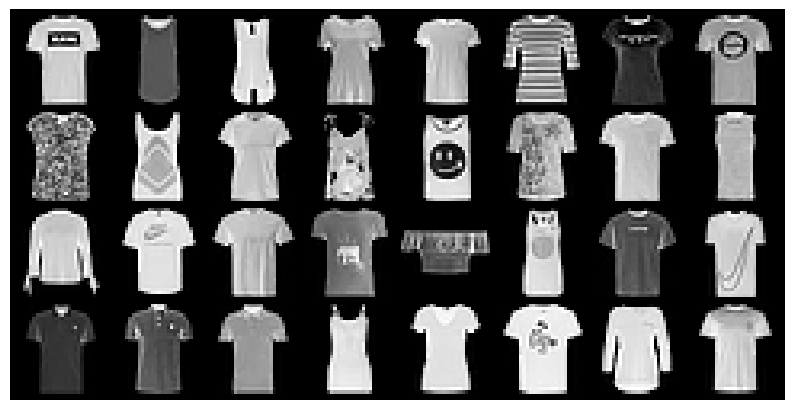

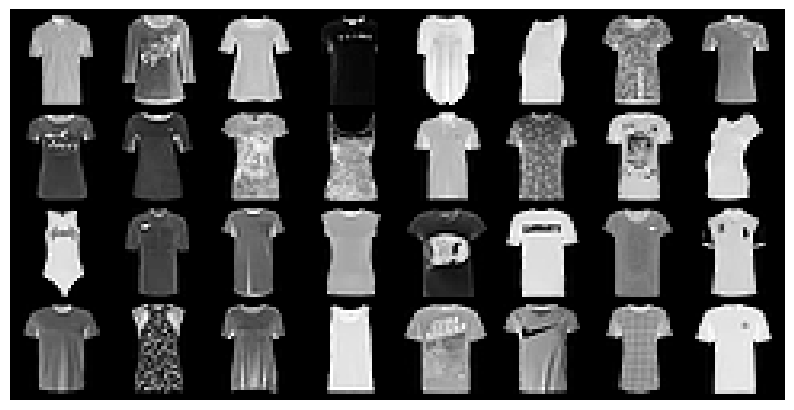

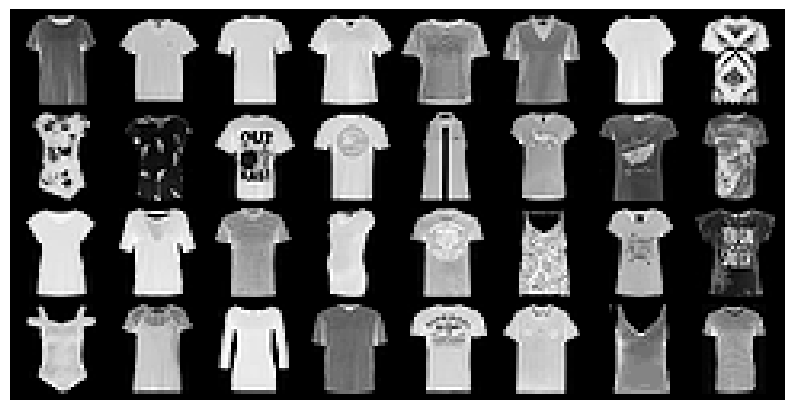

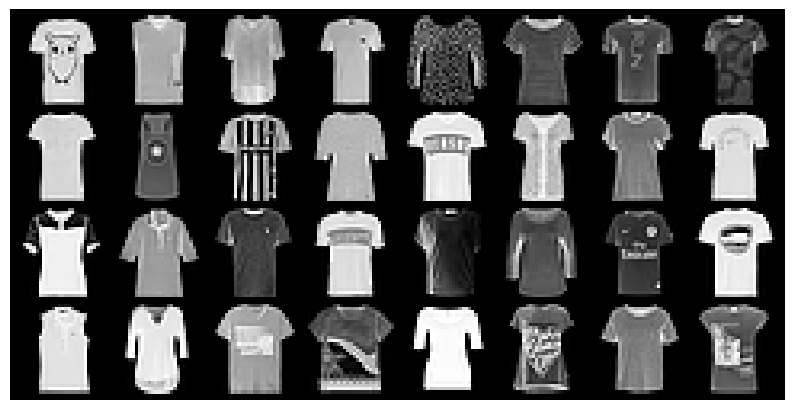

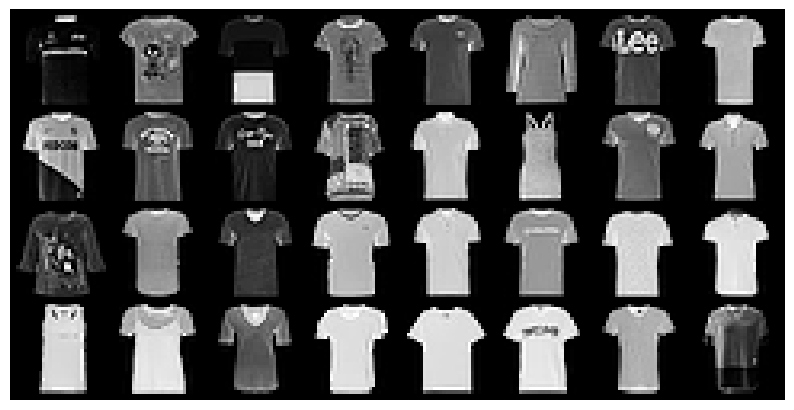

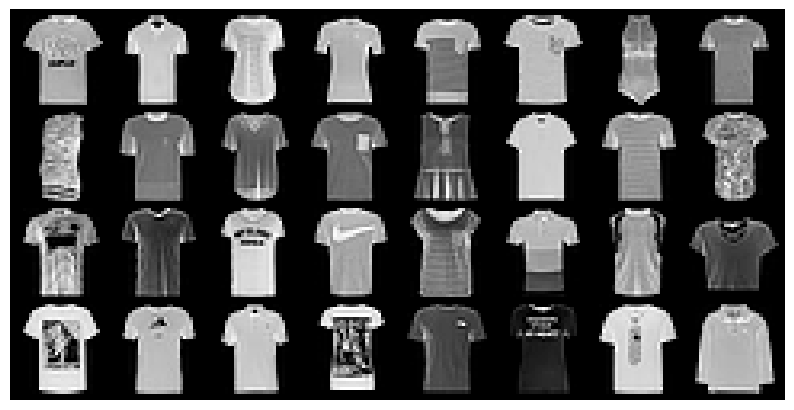

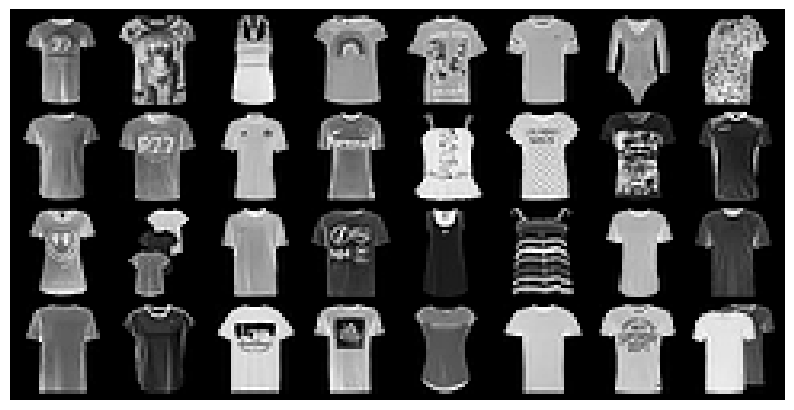

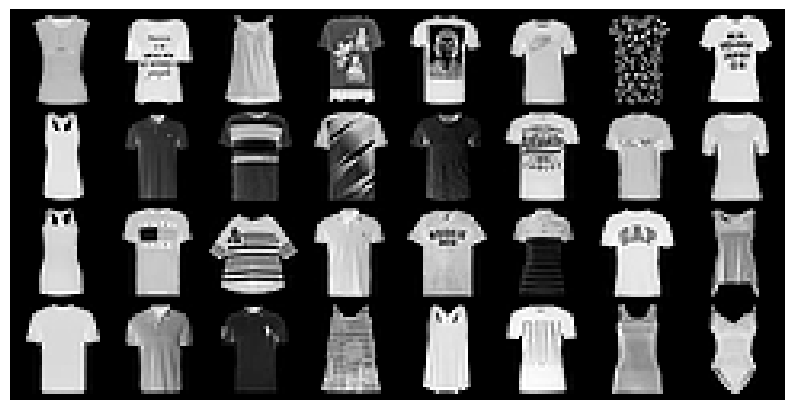

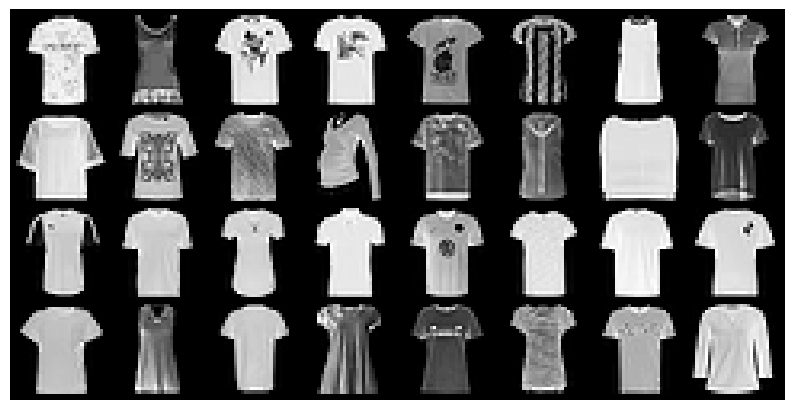

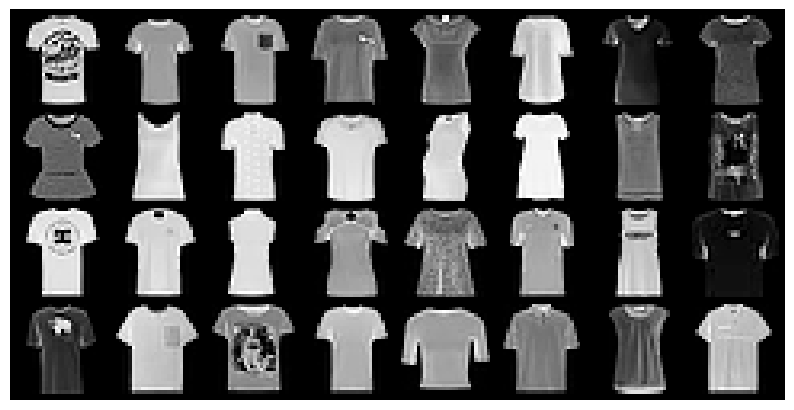

In [4]:
from torch.utils.data import DataLoader, Subset

# Step 1: download dataset (done)

# Step 2: Filter for a specific class (e.g., '0' for T-shirt/top)
class_index = 0
indices = [i for i, (_, label) in enumerate(train_dataset) if label == class_index]

# Selecting the first 128 images of the class
indices = indices[:128*10]

# Creating a subset with only the selected class
subset_dataset = Subset(train_dataset, indices)

# Step 3: Create a DataLoader for this subset
# Ensure to load all 128 images in one batch
subset_loader = DataLoader(subset_dataset, batch_size=128, shuffle=False)

# Assuming img_size, ripser_parallel, and plotdgm are defined elsewhere
img_size = 28 * 28  # For FashionMNIST

# Step 4: Process the batch
for batch_idx, (data, _) in enumerate(subset_loader):
    data = data.view(data.size(0), -1)
    points_np = data.view(-1, img_size).numpy()

    dgm2 = ripser_parallel(points_np, maxdim=1, return_generators=True)
    plotdgm(dgm2)

    plot_batch(data)

1. add noise to the images and see the change in the value of the regularizers

In [5]:
pts_batches = []
for batch_idx, (data, _) in enumerate(train_loader):
  pts_batches.append(data)
  dgms_batches.append(get_dgm(data.view(data.size(0), -1), 1))

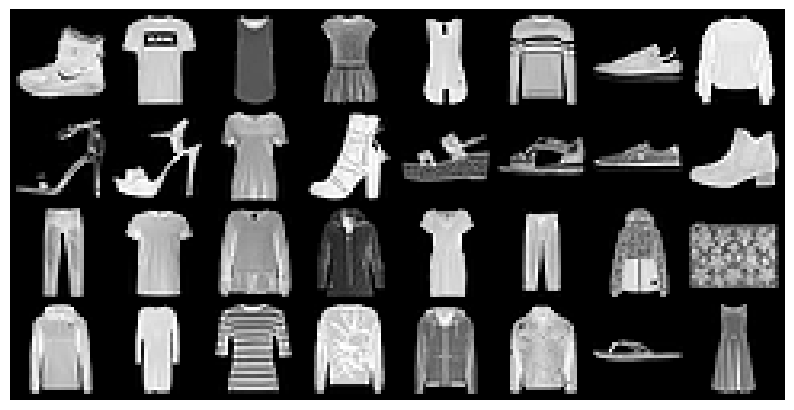

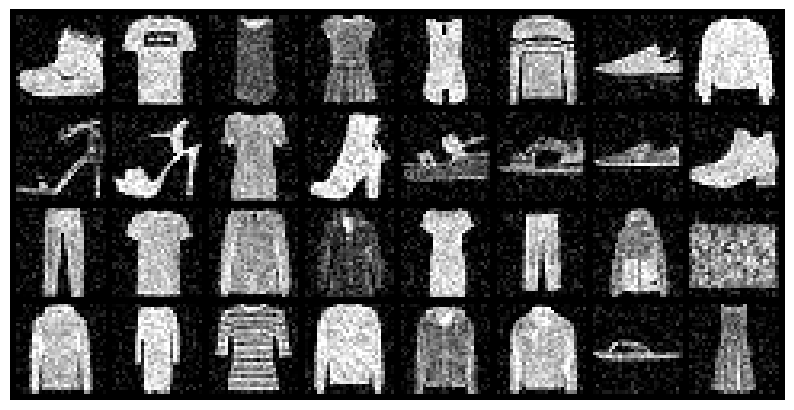

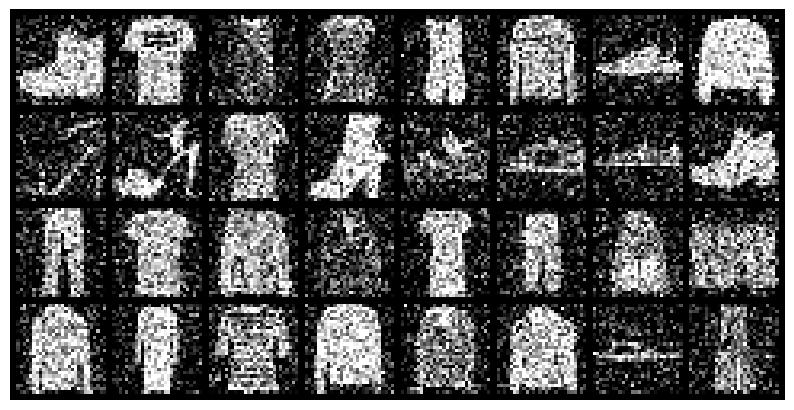

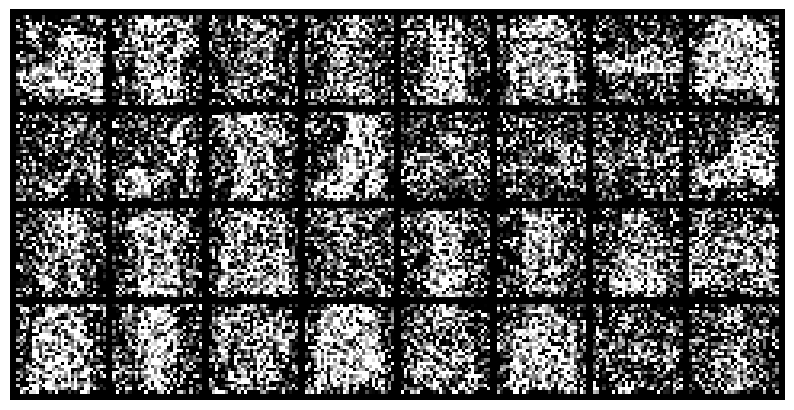

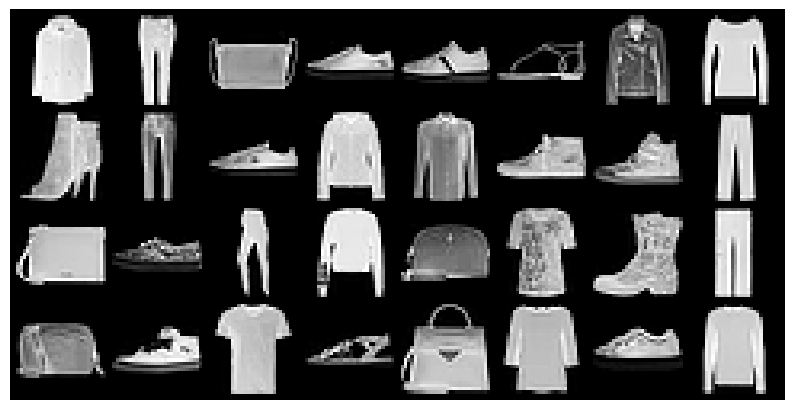

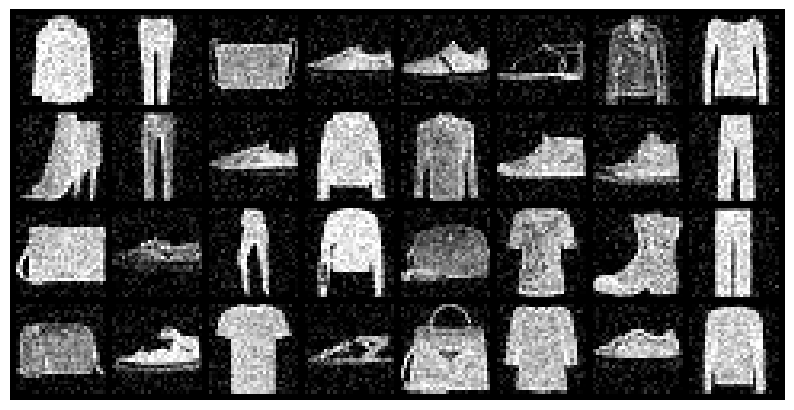

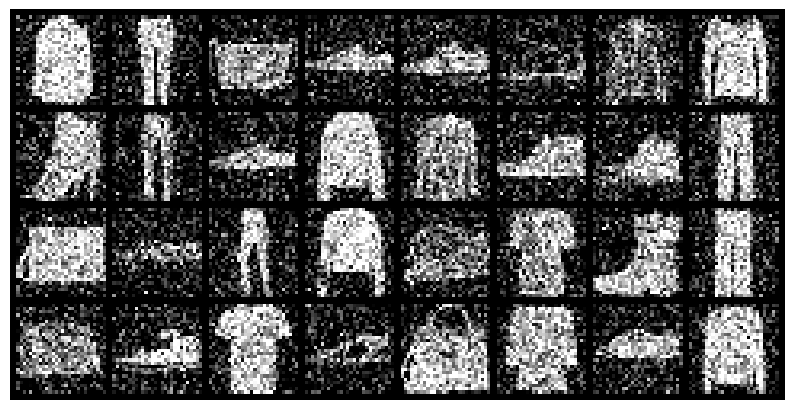

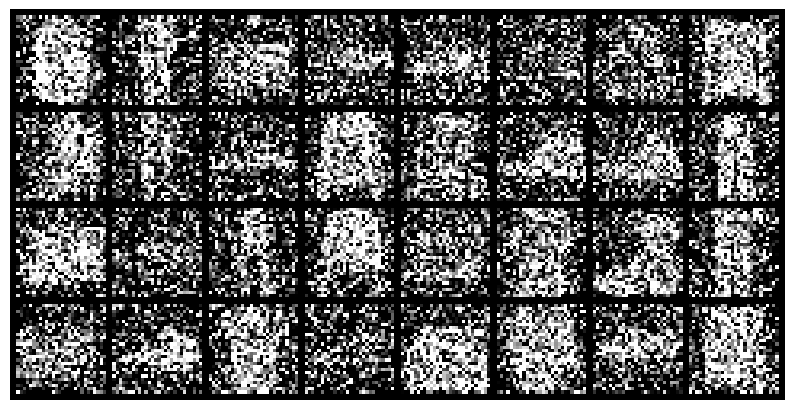

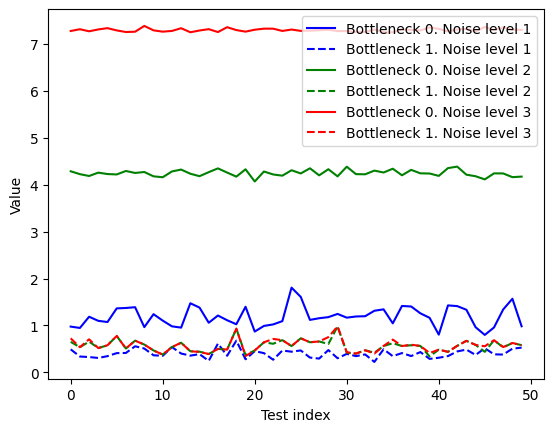

In [10]:
n = 50
pts1 = []
pts2 = []
pts3 = []
noisedgm1=[]
noisedgm2=[]
noisedgm3=[]

for i in range(n):
  data = pts_batches[i]

  noise1 = torch.clamp(data + torch.randn_like(data) * 0.1, 0, 1) # add gaussian noise
  noise2 = torch.clamp(data + torch.randn_like(data) * 0.3, 0, 1)
  noise3 = torch.clamp(data + torch.randn_like(data) * 0.7, 0, 1)
  pts1.append(noise1)
  pts2.append(noise2)
  pts3.append(noise3)
  noisedgm1.append(get_dgm(noise1.view(data.size(0), -1), 1))
  noisedgm2.append(get_dgm(noise2.view(data.size(0), -1), 1))
  noisedgm3.append(get_dgm(noise3.view(data.size(0), -1), 1))

  if i==0 or i==1:
    plot_batch(pts_batches[i])
    plot_batch(pts1[i])
    plot_batch(pts2[i])
    plot_batch(pts3[i])

# compute distance between noisedgm1[i] and dgm_batches[i]: (pt clouds: pts1[i] and pts_batches[i]):
l0s1=[]
l1s1=[]
l0s2=[]
l1s2=[]
l0s3=[]
l1s3=[]
for i in range(n):
  #noise level 1
  l0, g0 = d_bottleneck0(pts_batches[i], dgms_batches[i], noisedgm1[i]) #data is the pt cloud of dgm. dgm0 does not require a point cloud
  l1, g1 = d_bottleneck1(pts_batches[i], dgms_batches[i], noisedgm1[i])
  l0s1.append(l0)
  l1s1.append(l1)

  #noise level 2
  l0, g0 = d_bottleneck0(pts_batches[i], dgms_batches[i], noisedgm2[i]) #data is the pt cloud of dgm. dgm0 does not require a point cloud
  l1, g1 = d_bottleneck1(pts_batches[i], dgms_batches[i], noisedgm2[i])
  l0s2.append(l0)
  l1s2.append(l1)

  #noise level 3
  l0, g0 = d_bottleneck0(pts_batches[i], dgms_batches[i], noisedgm3[i]) #data is the pt cloud of dgm. dgm0 does not require a point cloud
  l1, g1 = d_bottleneck1(pts_batches[i], dgms_batches[i], noisedgm3[i])
  l0s3.append(l0)
  l1s3.append(l1)

# plot the 4 lists:
plt.plot(l0s1, label=f'Bottleneck 0. Noise level 1', color='blue')
plt.plot(l1s1, label=f'Bottleneck 1. Noise level 1', color='blue', linestyle='--')
plt.plot(l0s2, label=f'Bottleneck 0. Noise level 2', color='green')
plt.plot(l1s2, label=f'Bottleneck 1. Noise level 2', color='green', linestyle='--')
plt.plot(l0s3, label=f'Bottleneck 0. Noise level 3', color='red')
plt.plot(l1s3, label=f'Bottleneck 1. Noise level 3', color='red', linestyle='--')
plt.xlabel('Test index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [11]:
print(sum(l0s1)/len(l0s1), sum(l0s2)/len(l0s2), sum(l0s3)/len(l0s3))
print(sum(l1s1)/len(l1s1), sum(l1s2)/len(l1s2), sum(l1s3)/len(l1s3))

tensor(1.1895) tensor(4.2455) tensor(7.2953)
tensor(0.4019) tensor(0.5639) tensor(0.5764)


2. same but with pers entropy

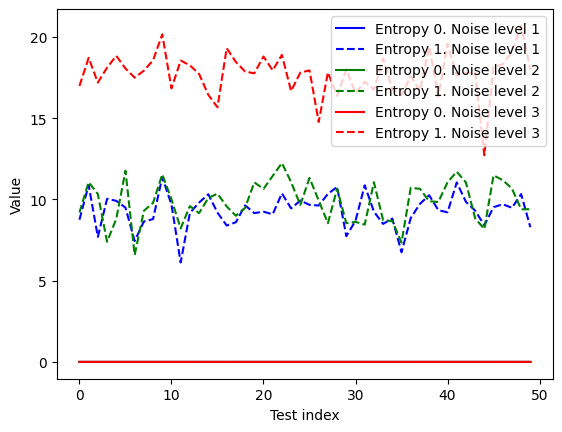

In [7]:
# compute distance between noisedgm1[i] and dgm_batches[i]: (pt clouds: pts1[i] and pts_batches[i]):
l0s1=[]
l1s1=[]
l0s2=[]
l1s2=[]
l0s3=[]
l1s3=[]
for i in range(n):
  #noise level 1
  l0, g0 = loss_persentropy0(pts_batches[i], dgms_batches[i], noisedgm1[i], 0.1)
  l1, g1 = loss_persentropy1(pts_batches[i], dgms_batches[i], noisedgm1[i], 0.1)
  if g0==1: l0s1.append(l0)
  if g1==1: l1s1.append(l1)

  #noise level 2
  l0, g0 = loss_persentropy0(pts_batches[i], dgms_batches[i], noisedgm2[i], 0.1)
  l1, g1 = loss_persentropy1(pts_batches[i], dgms_batches[i], noisedgm2[i], 0.1)
  if g0==1: l0s2.append(l0)
  if g1==1: l1s2.append(l1)

  #noise level 3
  l0, g0 = loss_persentropy0(pts_batches[i], dgms_batches[i], noisedgm3[i], 0.1)
  l1, g1 = loss_persentropy1(pts_batches[i], dgms_batches[i], noisedgm3[i], 0.1)
  if g0==1: l0s3.append(l0)
  if g1==1: l1s3.append(l1)

# plot the 4 lists:
plt.plot(l0s1, label=f'Entropy 0. Noise level 1', color='blue')
plt.plot(l1s1, label=f'Entropy 1. Noise level 1', color='blue', linestyle='--')
plt.plot(l0s2, label=f'Entropy 0. Noise level 2', color='green')
plt.plot(l1s2, label=f'Entropy 1. Noise level 2', color='green', linestyle='--')
plt.plot(l0s3, label=f'Entropy 0. Noise level 3', color='red')
plt.plot(l1s3, label=f'Entropy 1. Noise level 3', color='red', linestyle='--')
plt.xlabel('Test index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [8]:
print(sum(l0s1)/len(l0s1), sum(l0s2)/len(l0s2), sum(l0s3)/len(l0s3))
print(sum(l1s1)/len(l1s1), sum(l1s2)/len(l1s2), sum(l1s3)/len(l1s3))

tensor(9.6526e-05) tensor(0.0005) tensor(0.0006)
tensor(9.3091, dtype=torch.float64) tensor(9.8634, dtype=torch.float64) tensor(17.7186, dtype=torch.float64)


Train VAE:

In [ ]:
"""Train only conv-vae:"""

#model0 is normal VAE, models1-6 have topo losses:
n_epochs = 2
n_latent = 10
n_showplots = 100
model0 = VAE(n_latent)
optimizer0 = optim.Adam(model0.parameters(), lr=1e-3)
model0.train()
losses = []
losses2 = []

for epoch in range(n_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        if batch_idx==1: print("done")
        if batch_idx==10: print("done2")
        #data = data.view(data.size(0), -1)
        if batch_idx % n_showplots != 0 or batch_idx==0:
          optimizer0.zero_grad()

          recon_batch, mean, log_var = model0(data)
          loss = loss_vae0(recon_batch, data, mean, log_var, 0)
          loss.backward()
          optimizer0.step()

          if batch_idx % n_showplots == 1 and batch_idx > 100:
            print(f"Epoch {epoch+1}/{epochs} - Batch {batch_idx}/{len(train_loader)}")
            print("Input: real data (trained on)")
            with torch.no_grad():
                print("Real batch:")
                plot_batch(data)

                print("Model 0:")
                recon_batch, _, _ = model0(data)
                plot_batch(recon_batch)

        else: #ie batch_idx % n_showplots == 0 and >0:
            print(f"Epoch {epoch+1}/{epochs} - Batch {batch_idx}/{len(train_loader)}")
            print("Input: new data (not trained on) and input random latent vectors:")

            with torch.no_grad():
                print("Real batch:")
                plot_batch(data)

                sampled_latent = torch.randn(32, n_latent)
                #show imgs generated by the 7 models:

                print("Model 0:")
                recon_batch, _, _ = model0(data)
                plot_batch(recon_batch)
                generated_samples = model0.decoder(sampled_latent)
                plot_batch(generated_samples)

"""Train and compare model0 (normal VAE) and model2 (model2 is some TopoVAE model) (same structure but with topo-loss):"""

## hyperparameters:
n_epochs = 10
n_showplots = 25
n_latent = 10

## create 2 models with same parameters:
seed = 515
torch.manual_seed(seed)
model0 = VAE(n_latent)
torch.manual_seed(seed)
model2 = VAE(n_latent)

optimizer0 = optim.Adam(model0.parameters(), lr=1e-3)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)
model0.train()
model2.train()
losses = []
losses2 = []
lossestopo = []
lossestopo2 = []

for epoch in range(n_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):

        if batch_idx%n_showplots==0 and batch_idx>0:
          plt.plot(np.arange(len(losses)), losses, label='Conv-VAE')
          plt.plot(np.arange(len(lossestopo)), lossestopo, label='Conv-TopoVAE')
          plt.xlabel("Iteration")
          plt.ylabel("BCE loss")
          plt.legend(loc='upper right')
          plt.show()
          plt.plot(np.arange(len(losses2)), losses2, label='Conv-VAE')
          plt.plot(np.arange(len(lossestopo2)), lossestopo2, label='Conv-TopoVAE')
          plt.xlabel("Iteration")
          plt.ylabel("KLD loss")
          plt.legend(loc='upper right')
          plt.show()

        if batch_idx % n_showplots != 0 or batch_idx==0:
          #get dgm2:
          dgm2 = dgms_batches[batch_idx]

          #update the 2 models:
          optimizer0.zero_grad()
          optimizer2.zero_grad()

          #model0
          recon_batch, mean, log_var = model0(data)
          loss = loss_vae0(recon_batch, data, mean, log_var, 0)
          loss.backward()
          optimizer0.step()
          #model2
          recon_batch, mean, log_var = model2(data)
          dgm = get_dgm(recon_batch.view(data.size(0), -1), 1)
          ## replace the next line by the topo-loss of choice (or combination of topo-losses):
          loss = loss_fctn2(recon_batch, data, mean, log_var, dgm, dgm2, 15., 15.)
          # loss_fctn2(recon_batch, data, mean, log_var, dgm, dgm2, 5., 5.)
          # loss_fctn3(recon_batch, data, mean, log_var, dgm, dgm2, 5., 5., 0.1)
          # loss_fctn4(recon_batch, data, mean, log_var, dgm, dgm2, 10., 10., 0.1)
          # loss_fctn5(recon_batch, data, mean, log_var, dgm, dgm2, 5., 5.)
          loss.backward()
          optimizer2.step()

          if batch_idx % n_showplots == 1 and batch_idx > 100:
            print(f"Epoch {epoch+1}/{epochs} - Batch {batch_idx}/{len(train_loader)}")
            print("Input: real data (trained on)")
            with torch.no_grad():
                print("Real batch:")
                plot_batch(data)

                print("VAE0:")
                recon_batch, _, _ = model0(data)
                plot_batch(recon_batch)
                print("TopoVAE:")
                recon_batch, _, _ = model2(data)
                plot_batch(recon_batch)

        else: #ie batch_idx % n_showplots == 0 and >0:
            print(f"Epoch {epoch+1}/{epochs} - Batch {batch_idx}/{len(train_loader)}")
            print("Input: new data (not trained on) and input random latent vectors:")

            with torch.no_grad():
                print("Real batch:")
                plot_batch(data)

                print("VAE0:")
                recon_batch, _, _ = model0(data)
                plot_batch(recon_batch)

                print("TopoVAE:")
                recon_batch, _, _ = model2(data)
                plot_batch(recon_batch)

    print("end of epoch", epoch)
    plt.plot(np.arange(len(losses)), losses, label='VAE0')
    plt.plot(np.arange(len(lossestopo)), lossestopo, label='TopoVAE')
    plt.xlabel("Iteration")
    plt.ylabel("BCE loss")
    plt.legend(loc='upper right')
    plt.show()
    plt.plot(np.arange(len(losses2)), losses2, label='VAE0')
    plt.plot(np.arange(len(lossestopo2)), lossestopo2, label='TopoVAE')
    plt.xlabel("Iteration")
    plt.ylabel("KLD loss")
    plt.legend(loc='upper right')
    plt.show()